**Introduction**

Determining the legitimacy of an Instagram account is challenging. However, a predictive model can be constructed to gauge the probability of an account being fake, based on specific attributes and activity patterns. 

**Goal**

The objective is to determine if a user account is genuine or fake, which is classified as a binary classification problem due to the presence of two categories. Here, employ a combination of machine learning and deep learning models to leverage the strengths of both approaches.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import  accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import joblib

# Load data

The initial step involves loading the data and comprehending the dataset's information structure. 
Following that, we implement any required alterations to the dataset before proceeding with exploratory data analysis and modeling. 
There are two files available: one for training and another for testing. The target vector is determined by the 'fake' column.

In [2]:
train = pd.read_csv('kaggle_dataset/train.csv')
test = pd.read_csv('kaggle_dataset/test.csv') 
df = pd.concat([train, test], ignore_index=True)

the features are:
- Profile Picture: Binary indicator of whether an account has a profile picture or not.
- Numerical Characters to Username Length Ratio: Continuous feature representing the proportion of numerical characters in an account's username.
- Full Name Word Count: Continuous feature indicating the total number of words in the person's full name.
- Numerical Characters to Full Name Length Ratio: Continuous feature indicating the ratio of numerical characters to the total length of the person's full name.
- Name Matches Username: Binary feature indicating whether the person's name matches their username.
- Description Length: Length of the profile description, likely the bio.
- External URL in Bio: Binary feature indicating whether a profile has a link to an external website in its bio.
- Private Profile: Binary feature indicating whether the profile is restricted to non-followers.
- Number of Posts: Continuous feature representing the total number of posts on the profile.
- Number of Followers: Continuous feature representing the total number of followers for each account.
- Number of Follows: Continuous feature representing the total number of accounts that the user is following.
- Fake Account: Target variable indicating whether an account is fake or not.

In [3]:
df.head(4)

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0


#Exploratory Data Analysis

In [4]:
# dataset size
print(" size of dataset :",len(df))

 size of dataset : 696


In [5]:
# target count
target_count = df.fake.value_counts()
target_count

fake
0    348
1    348
Name: count, dtype: int64

In [6]:
print('target have {}% for non-fake and {}% for fake.'.format(round(100*(target_count[1]/target_count.sum())),
                                                                  round(100*(target_count[0]/target_count.sum()))))

target have 50% for non-fake and 50% for fake.


In [7]:
df.shape

(696, 12)

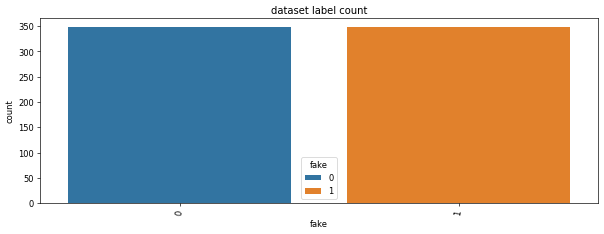

In [8]:
# graphical analysis
plt.figure(dpi=60,figsize=(12,4))
sns.countplot(x ='fake', data=df, hue = "fake")
plt.xticks(rotation =80)
plt.title('dataset label count')
plt.show()

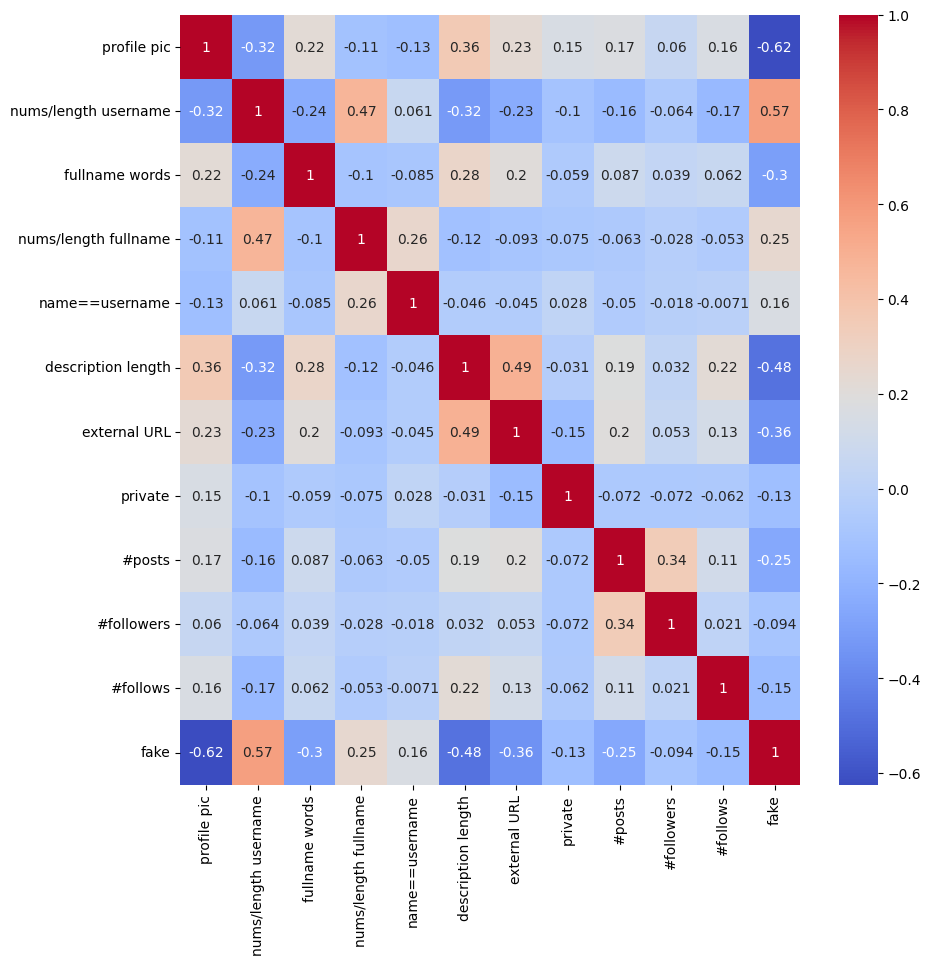

In [9]:
# correlation between features
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

plt.show()

In [10]:
# Check descriptive statistics
df.describe()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
count,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,6.960000e+02,696.000000,696.00000
mean,0.711207,0.166609,1.475575,0.042170,0.035920,23.412356,0.113506,0.369253,103.244253,7.914991e+04,555.086207,0.50000
std,0.453527,0.218964,1.076622,0.143664,0.186223,38.595721,0.317438,0.482950,378.028168,8.428875e+05,1023.613869,0.50036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.00000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.200000e+01,61.000000,0.00000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.655000e+02,252.000000,0.50000
75%,1.000000,0.330000,2.000000,0.000000,0.000000,35.000000,0.000000,1.000000,77.000000,6.930000e+02,601.750000,1.00000
max,1.000000,0.920000,12.000000,1.000000,1.000000,150.000000,1.000000,1.000000,7389.000000,1.533854e+07,7500.000000,1.00000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile pic           696 non-null    int64  
 1   nums/length username  696 non-null    float64
 2   fullname words        696 non-null    int64  
 3   nums/length fullname  696 non-null    float64
 4   name==username        696 non-null    int64  
 5   description length    696 non-null    int64  
 6   external URL          696 non-null    int64  
 7   private               696 non-null    int64  
 8   #posts                696 non-null    int64  
 9   #followers            696 non-null    int64  
 10  #follows              696 non-null    int64  
 11  fake                  696 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 65.4 KB


#Preprocessing

In [12]:
# Check  the missing values
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing (%)': percent_missing})
missing_value_df.sort_values('percent_missing (%)', ascending=False)

,percent_missing (%)
profile pic,0.0
nums/length username,0.0
fullname words,0.0
nums/length fullname,0.0
name==username,0.0
description length,0.0
external URL,0.0
private,0.0
#posts,0.0
#followers,0.0


In [13]:
# check nan values
df.isna().any()

profile pic             False
nums/length username    False
fullname words          False
nums/length fullname    False
name==username          False
description length      False
external URL            False
private                 False
#posts                  False
#followers              False
#follows                False
fake                    False
dtype: bool

In [14]:
# check  duplicated rows
df_duplicated = df[df.duplicated(keep=False)]
df_duplicated

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
196,1,0.00,2,0.0,0,48,0,0,222,5282,652,0
197,1,0.00,2,0.0,0,48,0,0,222,5282,652,0
491,1,0.91,1,0.0,0,0,0,0,0,75,26,1
525,1,0.91,1,0.0,0,0,0,0,0,75,26,1
637,1,0.27,1,0.0,0,0,0,0,0,45,64,1
639,0,0.00,1,0.0,1,0,0,0,0,69,694,1
643,0,0.00,1,0.0,1,0,0,0,0,69,694,1
659,1,0.27,1,0.0,0,0,0,0,0,45,64,1


In [15]:
# Removing duplicates
df.drop_duplicates(inplace = True)

In [16]:
# new dataset size
print(" size of dataset :",len(df))

 size of dataset : 692


In [17]:
target=np.array(df['fake'])
data = df.drop('fake',axis=1)
inp_data = np.array(data)
inp_data = np.float64(inp_data)

# dataspliting

In [18]:
# for machine learning
xtrain,xtest,ytrain,ytest = train_test_split(inp_data,target,test_size=0.2,random_state=100)

In [19]:
# for deep learning
x_train = xtrain.reshape((xtrain.shape[0],1,xtrain.shape[1]))
x_test = xtest.reshape((xtest.shape[0],1,xtest.shape[1]))

#SVM classifier (Machine Learning)

In [20]:
# svm training
svm = SVC()
svm.fit(xtrain,ytrain)

SVC()

In [21]:
predictions = svm.predict(xtest)
svm_acc = accuracy_score(ytest, predictions)
print("Accuracy svm : ",svm_acc)
print("        Accuracy: {:.2f}%".format(svm_acc*100))

Accuracy svm :  0.48201438848920863
        Accuracy: 48.20%


Confusion Matrix:
[[ 4 72]
 [ 0 63]]


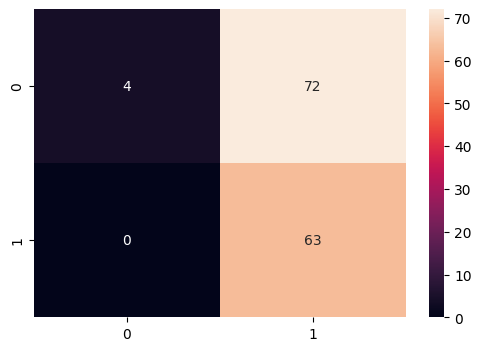

In [22]:
cm = confusion_matrix(ytest,predictions)
print("Confusion Matrix:\n{}".format(cm))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#KNN classifier (Machine Learning)

In [23]:
knn_mlmodel = KNeighborsClassifier(7).fit(xtrain, ytrain)
predictions = knn_mlmodel.predict(xtest)
knn_acc = accuracy_score(ytest,predictions)
#print("        Accuracy: {:.2f}%".format(knn_acc*100))

knn_cv_scores = cross_val_score(knn_mlmodel, xtrain, ytrain, cv=5)  # 5-fold cross-validation

knn_mean_accuracy=(np.mean(knn_cv_scores))

print(f'Average Validation Accuracy for ML Model: {knn_mean_accuracy*100:.2f}%')

Average Validation Accuracy for ML Model: 89.69%


Confusion Matrix:
[[69  7]
 [ 6 57]]


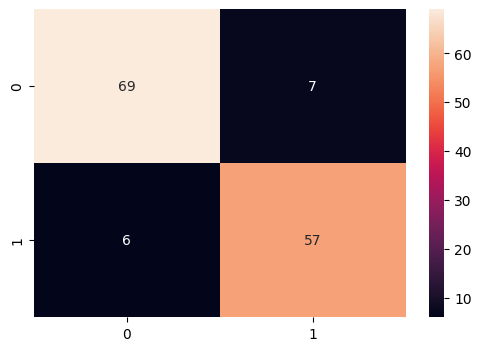

In [24]:

cm = confusion_matrix(ytest,predictions)
print("Confusion Matrix:\n{}".format(cm))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#Multi-Layer Perceptron Classifier

In [25]:
clf = MLPClassifier(random_state=1, max_iter=300).fit(xtrain, ytrain)

In [26]:
predictions = clf.predict(xtest)
clf_acc = accuracy_score(ytest,predictions)
print("        Accuracy: {:.2f}%".format(clf_acc*100))

        Accuracy: 76.98%


Confusion Matrix:
[[74  2]
 [30 33]]


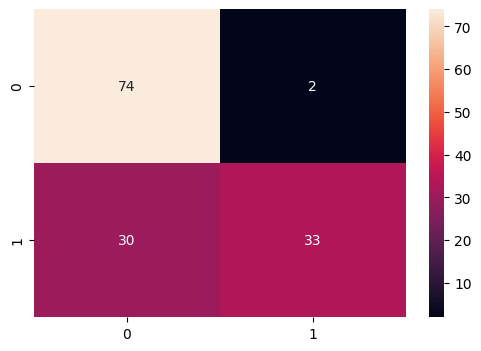

In [27]:
cm = confusion_matrix(ytest,predictions)
print("Confusion Matrix:\n{}".format(cm))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#LSTM

In [28]:
"""lstm_dlmodel = keras.Sequential()
lstm_dlmodel.add(tf.keras.layers.Conv1D(128,1, activation='relu',input_shape=(x_train.shape[1],11)))
lstm_dlmodel.add(tf.keras.layers.LSTM(25,return_sequences=True))
lstm_dlmodel.add(tf.keras.layers.SimpleRNN(20))
lstm_dlmodel.add(tf.keras.layers.Dense(400))
lstm_dlmodel.add(tf.keras.layers.ELU())
lstm_dlmodel.add(tf.keras.layers.Dropout(0.2))
lstm_dlmodel.add(tf.keras.layers.Dense(2, activation='softmax'))
lstm_dlmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_dlmodel.summary())"""

"""lstm_dlmodel = keras.Sequential()
lstm_dlmodel.add(tf.keras.layers.Input(shape=(x_train.shape[1], 11)))
lstm_dlmodel.add(tf.keras.layers.Conv1D(128,1, activation='relu',))
lstm_dlmodel.add(tf.keras.layers.LSTM(25,return_sequences=True))
lstm_dlmodel.add(tf.keras.layers.LSTM(50,return_sequences=True))
lstm_dlmodel.add(tf.keras.layers.SimpleRNN(20))
lstm_dlmodel.add(tf.keras.layers.Dense(400))
lstm_dlmodel.add(tf.keras.layers.Dropout(0.3))
lstm_dlmodel.add(tf.keras.layers.Dense(200))
lstm_dlmodel.add(tf.keras.layers.ELU())
lstm_dlmodel.add(tf.keras.layers.Dropout(0.2))
lstm_dlmodel.add(tf.keras.layers.Dense(2, activation='softmax'))
lstm_dlmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_dlmodel.summary())"""

from tensorflow.keras.callbacks import EarlyStopping

k = 5  # Number of folds for cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cv_accuracies = []  # Store the accuracy of each fold

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for train_index, val_index in kf.split(x_train):
    # Split data into training and validation sets
    X_train, X_val = x_train[train_index], x_train[val_index]
    y_train, y_val = ytrain[train_index], ytrain[val_index]
    
    # Build and compile the LSTM model  
    # Re-build the model in each fold to avoid data leakage
    lstm_dlmodel = keras.Sequential()
    lstm_dlmodel.add(tf.keras.layers.Input(shape=(X_train.shape[1], 11)))
    lstm_dlmodel.add(tf.keras.layers.Conv1D(128, 1, activation='relu'))
    lstm_dlmodel.add(tf.keras.layers.LSTM(25, return_sequences=True))
    lstm_dlmodel.add(tf.keras.layers.LSTM(50, return_sequences=True))
    lstm_dlmodel.add(tf.keras.layers.SimpleRNN(20))
    lstm_dlmodel.add(tf.keras.layers.Dense(400))
    lstm_dlmodel.add(tf.keras.layers.Dropout(0.3))
    lstm_dlmodel.add(tf.keras.layers.Dense(200))
    lstm_dlmodel.add(tf.keras.layers.ELU())
    lstm_dlmodel.add(tf.keras.layers.Dropout(0.2))
    lstm_dlmodel.add(tf.keras.layers.Dense(2, activation='softmax'))
    lstm_dlmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model with early stopping
    history = lstm_dlmodel.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=0, callbacks=[early_stopping])

    val_accuracy = history.history['val_accuracy'][-1]  # Last epoch validation accuracy
    cv_accuracies.append(val_accuracy)

lstm_mean_accuracy = np.mean(cv_accuracies)
print(f'Average Validation Accuracy for DL Model: {lstm_mean_accuracy * 100:.2f}%')


Average Validation Accuracy for DL Model: 85.34%


In [29]:
#history = lstm_dlmodel.fit(x_train,ytrain,epochs=80, validation_split=0.2)

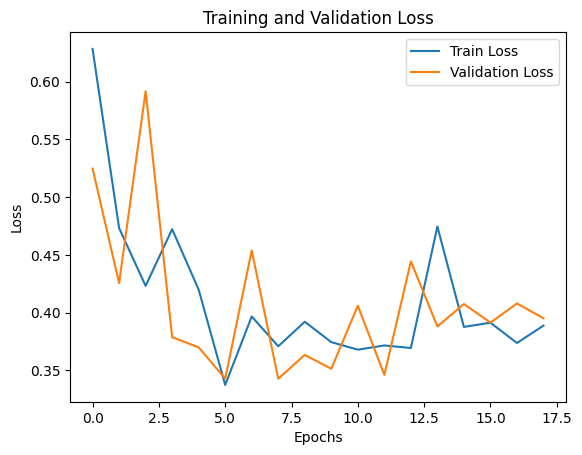

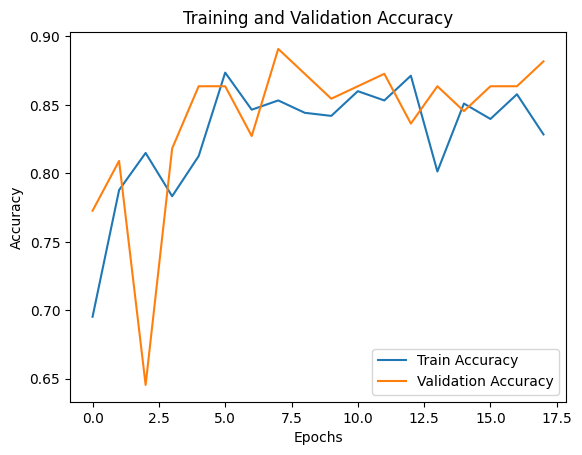

<Figure size 640x480 with 0 Axes>

In [30]:

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss') 

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc') 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
Confusion Matrix:
[[71  5]
 [19 44]]


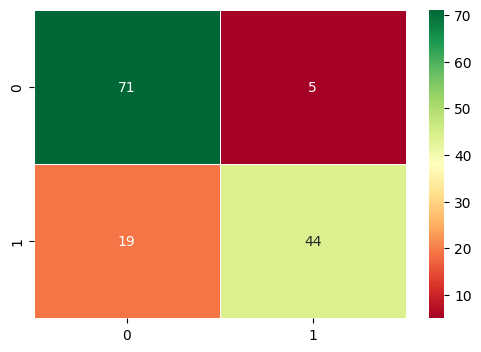

In [31]:
pred = lstm_dlmodel.predict(x_test)
pred = np.argmax(pred,axis=1)
lstm_acc = accuracy_score(ytest, pred)
cm = confusion_matrix(ytest, pred)
#print("        Accuracy: {:.2f}%".format(lstm_acc*100))

print("Confusion Matrix:\n{}".format(cm))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",cmap='RdYlGn',linewidths=0.5)
plt.show()

In [32]:
joblib.dump(knn_mlmodel, 'knn_model.pkl')
lstm_dlmodel.save('lstm_model.h5') 

#fusion

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Weight for LSTM (w1): 0.48758118732935485
Weight for KNN (w2): 0.5124188126706452
        Accuracy: 88.49%
Confusion Matrix:
[[71  5]
 [11 52]]


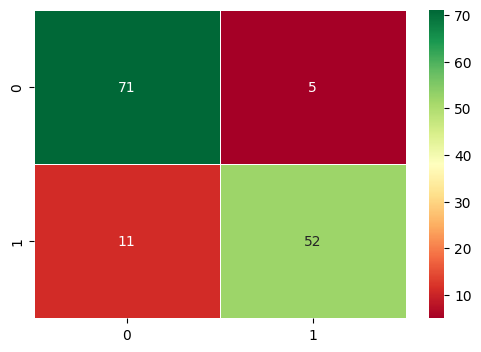

In [33]:
def get_result(xtest,knn_mlmodel,lstm_dlmodel):
  pb2 = knn_mlmodel.predict_proba(xtest)
  x_test = xtest.reshape((xtest.shape[0],1,xtest.shape[1]))
  pb1 = lstm_dlmodel.predict(x_test)
  w1 = lstm_mean_accuracy / (lstm_mean_accuracy + knn_mean_accuracy)
  w2 = knn_mean_accuracy / (lstm_mean_accuracy + knn_mean_accuracy)
  print(f"Weight for LSTM (w1): {w1}")
  print(f"Weight for KNN (w2): {w2}")
  pb = w1*pb1 + w2*pb2
  pred = np.argmax(pb,axis=1)
  return pred
pred = get_result(xtest,knn_mlmodel,lstm_dlmodel)
acc = accuracy_score(ytest, pred)
cm = confusion_matrix(ytest, pred)
print("        Accuracy: {:.2f}%".format(acc*100))
print("Confusion Matrix:\n{}".format(cm))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",cmap='RdYlGn',linewidths=0.5)
plt.show()

In [34]:
xtest.shape

(139, 11)

In [35]:
!jupyter nbconvert --to script ml_dl_fusion.ipynb

[NbConvertApp] Converting notebook ml_dl_fusion.ipynb to script
[NbConvertApp] Writing 11724 bytes to ml_dl_fusion.py
